# Approach:-

1. First step is to clean the data.
2. Process the text.Use only valuable word in sentence and remove the other character like special character.
3. Data is Imbalance. So, upsampling used it overcome this problem.
4. Use some simple feature engineering task on text like bagofword, tfidf and use word embedding from glove of 300 dimension.
5. Train model on the created feature vector.

# Metrics :- 
  1.) Auc <br>
  2.) Confusion Matrix,Precision,Recall Matrix






In [56]:
# import library
import tensorflow as tf
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

import seaborn as sns

In [23]:
# import data 

data = pd.read_json('/content/drive/MyDrive/MaliciousDetectingTask.json')
data_features = pd.json_normalize(data['req'])

In [24]:
data_features.head(4)

,baseUrl,fresh,hostname,ip,ips,originalUrl,path,protocol,secure,stale,subdomains,xhr,body.note.title,body.note.desc,headers.host,headers.user-agent,headers.content-type,headers.org_id,headers.user_session_id,headers.accept,headers.content-length,headers.user.name,headers.user.role
0,/crm/note,False,example.com,::ffff:117.99.96.244,[],/crm/note,/note,http,False,True,[crm],False,Tina Johnson,Top recognize eat. Fact whom spend area thing ...,example.com,insomnia/2020.4.2,application/json,5f572820f65af8ac955b2e83,5fb27d3750b11901a35649fe,*/*,70,sam,sales1
1,/crm/note,False,example.com,::ffff:117.99.96.244,[],/crm/note,/note,http,False,True,[crm],False,Clayton Cooper,As possible American many prepare four strong....,example.com,insomnia/2020.4.2,application/json,5f572820f65af8ac955b2e83,5fb27d3750b11901a35649fe,*/*,70,sam,sales1
2,/crm/note,False,example.com,::ffff:117.99.96.244,[],/crm/note,/note,http,False,True,[crm],False,Curtis Wolfe,Tuesday Notes or 2 like 2 XSP Class,example.com,insomnia/2020.4.2,application/json,5f572820f65af8ac955b2e83,5fb27d3750b11901a35649fe,*/*,70,sam,sales1
3,/crm/note,False,example.com,::ffff:117.99.96.244,[],/crm/note,/note,http,False,True,[crm],False,Laura Fisher,State third represent energy campaign not forg...,example.com,insomnia/2020.4.2,application/json,5f572820f65af8ac955b2e83,5fb27d3750b11901a35649fe,*/*,70,sam,sales1


In [25]:
data_features = data_features[['body.note.title','body.note.desc']]
data_features['isSafe'] = data['isSafe']
data_features.columns = ['Title','Description','IsSafe']
data_features.head()

,Title,Description,IsSafe
0,Tina Johnson,Top recognize eat. Fact whom spend area thing ...,True
1,Clayton Cooper,As possible American many prepare four strong....,True
2,Curtis Wolfe,Tuesday Notes or 2 like 2 XSP Class,False
3,Laura Fisher,State third represent energy campaign not forg...,True
4,Tyler Santos,Us enjoy since. Time identify image position o...,False


In [26]:
print("Safe File =",data_features[data_features['IsSafe']==False]['IsSafe'].count())
print("Unsafe File = ",data_features[data_features['IsSafe']==True]['IsSafe'].count())

Safe File = 428
Unsafe File =  572


In [27]:
#https://gist.githubusercontent.com/sebleier/554280/raw/7e0e4a1ce04c2bb7bd41089c9821dbcf6d0c786c/NLTK's%2520list%2520of%2520english%2520stopwords
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've","you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', ' while', 'of',
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under' , 'again', 'further', 
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'e ach', 'few', 'more', 
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll' , 'm', 'o', 're',
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "do esn't", 'hadn',
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 
            'won', "won't", 'wouldn', "wouldn't"]

In [28]:

import re
def cleaning_sentence(data):
  preprocessed_desp = []
  for sentance in data: 
    sent = sentance.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z]+', ' ', sent)
    # https://gist.github.com/sebleier/554280 
    sent = ' '.join(e for e in sent.split() if e not in stopwords) 
    sent = sent.lower().strip()
    sent = sent.replace('cvideo','video')
    sent = sent.replace('onerror','error')
    sent = sent.replace('aalert','alert')
    sent = sent.replace('fvideo','video')
    preprocessed_desp.append(sent)
  return preprocessed_desp

# Train Test Split

In [29]:
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_features['Description'].values, data_features['IsSafe'].values, test_size=0.30, random_state=42)
print("X_train shape = ",X_train.shape)
print("X_test shape = ",X_test.shape)

X_train shape =  (700,)
X_test shape =  (300,)


## Upsampling

In [30]:
train_dict  = {'Description':X_train,'label':y_train}
data = pd.DataFrame.from_dict(train_dict)
data[data['label']==False].count()

Description    301
label          301
dtype: int64

In [31]:
train_dict  = {'Description':X_train,'label':y_train}
data = pd.DataFrame.from_dict(train_dict)
false_label = data[data['label']==False].sample(98)
combine = pd.concat([data,false_label])
print("False label = ",combine[combine['label']==False]['label'].count())
print("True label = ",combine[combine['label']==True]['label'].count())

False label =  399
True label =  399


In [32]:
X_train = combine['Description'].values
y_train = combine['label'].values

## Cleaning Text

In [33]:
X_train = cleaning_sentence(X_train)
X_test = cleaning_sentence(X_test)


## Encoding Label

In [34]:

le = LabelEncoder()
le.fit(y_train)
Y_train = le.transform(y_train)
Y_test = le.transform(y_test)


# Feature Engineering

In [35]:
import numpy as np

def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel
GloveVector = loadGloveModel('/content/drive/MyDrive/glove.6B.300d.txt')

Loading Glove Model
400000  words loaded!


## Bag of Words 

In [36]:
from sklearn.feature_extraction.text import CountVectorizer 
vectorizer = CountVectorizer(min_df=6,ngram_range=(1,2)) 
vectorizer.fit(X_train)
bow_train = vectorizer.transform(X_train)
bow_test = vectorizer.transform(X_test)
print(bow_train.shape)
print(bow_test.shape)

(798, 910)
(300, 910)


## TFIDF VECTORIZATION

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=2)
vectorizer.fit(X_train)
tfidf_train = vectorizer.transform(X_train)
tfidf_test = vectorizer.transform(X_test)
print(tfidf_train.shape)
print(tfidf_test.shape)

(798, 954)
(300, 954)


## Average word2vec

In [38]:
def avg_w2v(data):
  avg_w2v_vectors = [];
  glove_key = GloveVector.keys()
  # the avg-w2v for each sentence/review is stored in this list
  for sentence in data:
    # for each review/sentence
    vector = np.zeros(300)

    # as word vectors are of zero length
    cnt_words =0;
    # num of words with a valid vector in the sentence/review 
    for word in sentence.split():
      # for each word in a review/sentence
      if word in glove_key:
        vector += GloveVector[word]
        cnt_words += 1
    if cnt_words != 0:
      vector /= cnt_words
      avg_w2v_vectors.append(vector)
  return np.array(avg_w2v_vectors)
avgw2v_train = avg_w2v(X_train)
avgw2v_test = avg_w2v(X_test)
print(avgw2v_train.shape)
print(avgw2v_test.shape)

(798, 300)
(300, 300)


## Tfidf Word2vec

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_weighted_w2v(data,tfidf_words):
    glove_words  = GloveVector.keys()
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in data:
      # for each review/sentence
      vector = np.zeros(300)
      # as word vectors are of zero length
      tf_idf_weight =0; 
      # num of words with a valid vector in the sentence/review
      for word in sentence.split():
        # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
          vec = GloveVector[word] 
          # getting the vector for each word
          # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split()))) 
          tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word 
          vector += (vec * tf_idf) 
          # calculating tfidf weighted w2v 
          tf_idf_weight += tf_idf 
      if tf_idf_weight != 0:
        vector /= tf_idf_weight
      tfidf_w2v_vectors.append(vector)
    return np.array(tfidf_w2v_vectors)
    
tfidf_model = TfidfVectorizer(min_df=2)
tfidf_model.fit(X_train)# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())
wtw2v_train=tfidf_weighted_w2v(X_train,tfidf_words)
wtw2v_test=tfidf_weighted_w2v(X_test,tfidf_words)
print(wtw2v_train.shape)
print(wtw2v_test.shape)

(798, 300)
(300, 300)


# Training Model

In [40]:
def hyper_parameterTuning(rand_search):
  vector_name = ['Bag of words--','Tfidf--','Average_w2v--','Tfidf_weight_vec--']

  for i,vector in enumerate([bow_train,tfidf_train,avgw2v_train,wtw2v_train]):
    print(vector_name[i])
    rand_search.fit(vector,Y_train)
    print(rand_search.best_params_)
    print(rand_search.best_score_)
    


In [59]:
def plot_confusionMatrix(predicted_y,true_y):
  y_true = ["False","True"]
  y_pred = ["False","True"]
  data = confusion_matrix(true_y, predicted_y)
  recall_mat = (((data.T)/(data.sum(axis=1))).T)
  precision_mat = (data/data.sum(axis=0))
  plt.figure(figsize=(20,4))
  cmap=sns.light_palette("blue")
  labels = ['False','True']
  plt.subplot(1, 3, 1)
  sns.heatmap(data, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Confusion matrix")
  
  plt.subplot(1, 3, 2)
  sns.heatmap(precision_mat, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Precision matrix")
  plt.subplot(1, 3, 3) 
  # representing B in heatmap format 
  sns.heatmap(recall_mat, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Recall matrix")
  plt.show()

In [62]:
from sklearn.linear_model import LogisticRegression
vector_name = ['Bag of words--','Tfidf--','Average_w2v--','Tfidf_weight_vec--']

params = {'penalty': ['l1', 'l2', 'elasticnet, none'],
          'C' : np.linspace(start = 0.001, stop = 1, num = 200)
          }
clf = LogisticRegression(n_jobs=-1)
rand_search = RandomizedSearchCV(clf,params,n_jobs = -1,cv=3,return_train_score=True,scoring='roc_auc',verbose=0)
for i,vector in enumerate([bow_train,tfidf_train,avgw2v_train,wtw2v_train]):
  print(vector_name[i])
  rand_search.fit(vector,Y_train)
  print(rand_search.best_params_)
  print(rand_search.best_score_)
  

Bag of words--
{'penalty': 'l2', 'C': 0.5481909547738694}
0.9041212052688111
Tfidf--
{'penalty': 'l2', 'C': 0.4929698492462312}
0.89196675900277
Average_w2v--
{'penalty': 'l2', 'C': 0.6084321608040202}
0.8480976878285941
Tfidf_weight_vec--
{'penalty': 'l2', 'C': 0.8945778894472363}
0.8444230877946746


In [57]:
clf = LogisticRegression(penalty='l2',C= 0.5481909547738694)
clf.fit(bow_train,Y_train)
predicted_trainy = clf.predict_proba(bow_train)[:,1]
predicted_testy = clf.predict_proba(bow_test)[:,1]
print(roc_auc_score(Y_train,predicted_trainy))
print(roc_auc_score(Y_test,predicted_testy))

1.0
0.8158481634882345


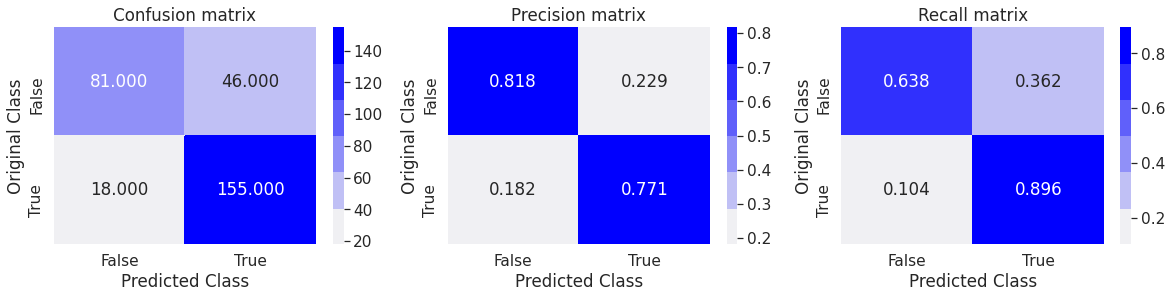

In [60]:
predicted_testy = clf.predict(bow_test)
plot_confusionMatrix(predicted_testy,Y_test)

In [174]:

params  = {'C' :np.linspace(start = 0.001, stop = 1, num = 200)}
clf = SVC()
rand_search = RandomizedSearchCV(clf,params,n_jobs = -1,cv=3,return_train_score=True,scoring='roc_auc',verbose=0)
hyper_parameterTuning(rand_search)
  

Bag of words--
{'C': 0.9447788944723619}
0.8930974051670529
Tfidf--
{'C': 0.8845376884422111}
0.8922117323383647
Average_w2v--
{'C': 0.9046180904522614}
0.8358301769461246
Tfidf_weight_vec--
{'C': 0.9849396984924624}
0.834341492829819


In [72]:
from sklearn.svm import SVC

In [61]:
clf = SVC(C= 0.9447788944723619)
clf.fit(bow_train,Y_train)
predicted_trainy = clf.decision_function(bow_train)
predicted_testy = clf.decision_function(bow_test)
print(roc_auc_score(Y_train,predicted_trainy))
print(roc_auc_score(Y_test,predicted_testy))

1.0
0.8194438122980293


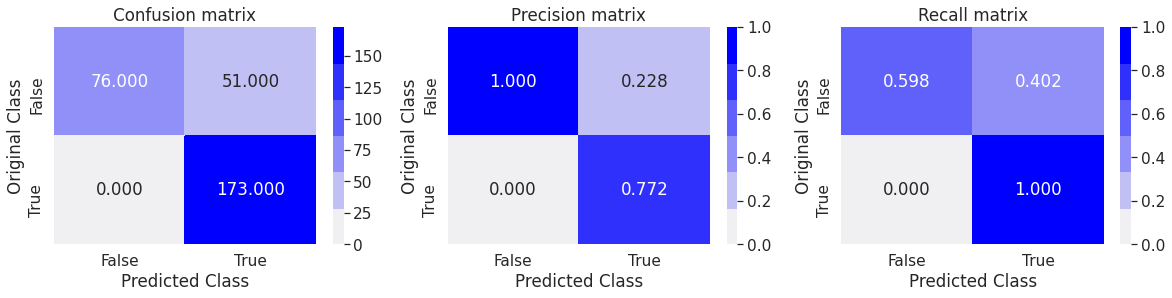

In [62]:
predicted_testy = clf.predict(bow_test)
plot_confusionMatrix(predicted_testy,Y_test)

## RandomForest 

In [20]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Critere for spliting
criterion = ['gini', 'entropy']
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 200, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14,7,9]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion':criterion}
classifier = RandomForestClassifier(n_jobs = -1)
rf_random = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
hyper_parameterTuning(rf_random)


Bag of words--
{'n_estimators': 2000, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 107, 'criterion': 'entropy', 'bootstrap': True}
0.8959899749373433
Tfidf--
{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 200, 'criterion': 'entropy', 'bootstrap': True}
0.8897243107769423
Average_w2v--
{'n_estimators': 200, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 35, 'criterion': 'entropy', 'bootstrap': False}
0.893483709273183
Tfidf_weight_vec--
{'n_estimators': 1000, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 56, 'criterion': 'entropy', 'bootstrap': False}
0.8922305764411028


In [63]:
clf = RandomForestClassifier(n_estimators= 1200, min_samples_split= 5, min_samples_leaf= 4, max_features= 'auto', max_depth= 87, criterion= 'entropy', class_weight= 'balanced', bootstrap= True)
clf.fit(bow_train,Y_train)
predicted_trainy = clf.predict_proba(bow_train)[:,1]
predicted_testy = clf.predict_proba(bow_test)[:,1]
print(roc_auc_score(Y_train,predicted_trainy))
print(roc_auc_score(Y_test,predicted_testy))

0.9997236198265086
0.8232670338173046


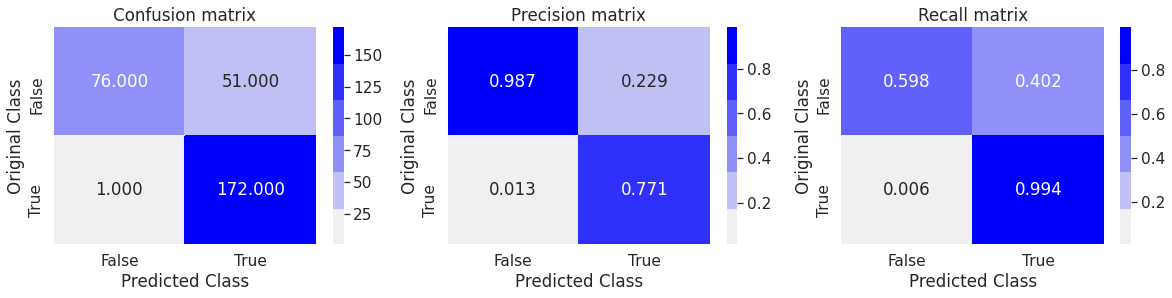

In [64]:
predicted_testy = clf.predict(bow_test)
plot_confusionMatrix(predicted_testy,Y_test)

## GradienBoosting Tree

In [22]:
gridParams = {
    'learning_rate': [0.1, 0.05, 0.01, 0.005,0.001,0.02,0.5],
    'n_estimators': [int(x) for x in np.linspace(start = 50,stop = 1000,num = 12)],
    }
clf=GradientBoostingClassifier()
Gridcv1 = RandomizedSearchCV(clf,gridParams,cv=3,scoring='roc_auc',return_train_score=True)
hyper_parameterTuning(Gridcv1)

Bag of words--
{'n_estimators': 395, 'learning_rate': 0.5}
0.8826012399419603
Tfidf--
{'n_estimators': 740, 'learning_rate': 0.02}
0.8759869598809052
Average_w2v--
{'n_estimators': 481, 'learning_rate': 0.05}
0.8898373753933706
Tfidf_weight_vec--
{'n_estimators': 654, 'learning_rate': 0.1}
0.8928901200369345


In [65]:
clf=GradientBoostingClassifier(n_estimators=654,learning_rate=0.1)

clf.fit(tfidf_train,Y_train)
predicted_trainy = clf.predict_proba(tfidf_train)[:,1]
predicted_testy = clf.predict_proba(tfidf_test)[:,1]
print(roc_auc_score(Y_train,predicted_trainy))

print(roc_auc_score(Y_test,predicted_testy))

1.0
0.829457011515179


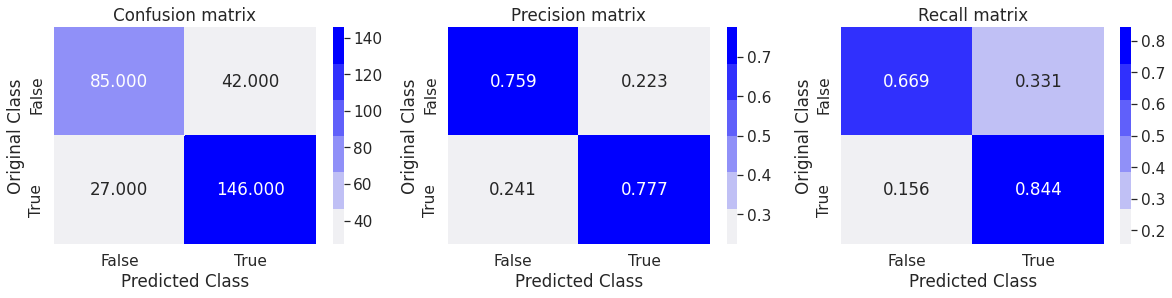

In [66]:
predicted_testy = clf.predict(tfidf_test)
plot_confusionMatrix(predicted_testy,Y_test)

# Conclusion :


1. GradientBoostingDecisionTree perform best among all the model.
2. Most model predict Unsafe model to safe because of imbalance dataset.
2. There is some imporvement in this model.

